In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ..."},
 {'url': 'https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787',
  'content': "However, LangGraph brings a bunch of additional concepts. Let's discuss them. LangGraph is created to define cyclical graphs. Graphs consist of the following elements: Nodes represent actual actions and can be either LLMs, agents or functions. Also, a special END node marks the end of execution."}]

In [3]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [26]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [27]:
graph_builder = StateGraph(State)

In [28]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [29]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [30]:
# from langgraph.prebuilt import ToolNode, tools_condition

tool_node = BasicToolNode(tools=[tool])

In [31]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [32]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [33]:
graph_builder.add_node("chatbot", chatbot)

In [34]:
graph_builder.add_edge(START, "chatbot")


In [35]:
graph_builder.add_edge("tools", "chatbot")

In [36]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)

In [37]:
graph = graph_builder.compile()

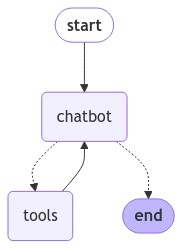

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [45]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


In [46]:
def stream_graph_updates_pretty_print(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].pretty_print())

In [47]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates_pretty_print(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates_pretty_print(user_input)
        break

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_9wUdYQ4BhYXYS0VYot1udhqv)
 Call ID: call_9wUdYQ4BhYXYS0VYot1udhqv
  Args:
    query: Elon Musk news
Assistant: None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.reuters.com/business/elon-musk/", "content": "Reuters.com is your online source for the latest Elon Musk news stories and current events, ensuring our readers up to date with any breaking news developments"}, {"url": "https://www.cnn.com/2024/09/17/business/elon-musk-richest-person-trillionaire/index.html", "content": "Elon Musk is on track to become the world\u2019s first trillionaire very soon | CNN Business CNN10 About CNN Elon Musk is on track to soon become the world\u2019s first trillionaire Elon Musk\u2019s sprawling empire \u2014 spanning everything from electric vehicles and social media to space rocket